<a href="https://colab.research.google.com/github/ijazahmad-star/Colab-Workspace/blob/main/oct%2020%202025/LangGraph_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import userdata
api_key = userdata.get('GOOGLE_API_KEY')

In [3]:
!pip install -U langchain_google_genai

  Using cached langchain_core-1.0.0-py3-none-any.whl.metadata (3.4 kB)
Using cached langchain_core-1.0.0-py3-none-any.whl (467 kB)
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.0 which is incompatible.


## Graph API

In [4]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash",
    temperature=0,
    google_api_key = api_key
)


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [5]:
tools_by_name

{'add': StructuredTool(name='add', description='Adds a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x78a0c8f4cea0>),
 'multiply': StructuredTool(name='multiply', description='Multiply a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x78a0c8f4ce00>),
 'divide': StructuredTool(name='divide', description='Divide a and b.\n\n    Args:\n        a: first int\n        b: second int', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x78a0c8f4cf40>)}

In [6]:
!pip install langchain.messages

ERROR: Could not find a version that satisfies the requirement langchain.messages (from versions: none)
ERROR: No matching distribution found for langchain.messages


In [8]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

In [9]:
from langchain_core.messages import SystemMessage
def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [10]:
from langchain_core.messages import ToolMessage

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [12]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 15.6 MB/s eta 0:00:00


In [13]:
from typing import Literal
from langgraph.graph import StateGraph, START, END

def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"
    # Otherwise, we stop (reply to the user)
    return END

In [14]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

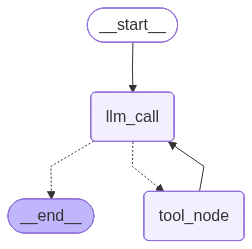

In [15]:
# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [17]:
# Invoke
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4. and what is 6 multiply by 7")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. and what is 6 multiply by 7
================================== Ai Message ==================================
Tool Calls:
  add (2349cb31-303f-48cc-a2b6-dc719054208d)
 Call ID: 2349cb31-303f-48cc-a2b6-dc719054208d
  Args:
    a: 3
    b: 4
  multiply (abc4ee39-9b0e-4a31-bfb6-a358f1337da0)
 Call ID: abc4ee39-9b0e-4a31-bfb6-a358f1337da0
  Args:
    a: 6
    b: 7
================================= Tool Message =================================

7
================================= Tool Message =================================

42
================================== Ai Message ==================================

The sum of 3 and 4 is 7. The product of 6 and 7 is 42.


## Functional api

In [19]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash",
    temperature=0,
    google_api_key = api_key
)

# llm = init_chat_model(
#     "anthropic:claude-sonnet-4-5",
#     temperature=0
# )


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

from langgraph.graph import add_messages
from langchain_core.messages import (
    SystemMessage,
    HumanMessage,
    BaseMessage,
    ToolCall,
)
from langgraph.func import entrypoint, task

In [20]:
@task
def call_llm(messages: list[BaseMessage]):
    """LLM decides whether to call a tool or not"""
    return llm_with_tools.invoke(
        [
            SystemMessage(
                content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
            )
        ]
        + messages
    )

In [21]:
@task
def call_tool(tool_call: ToolCall):
    """Performs the tool call"""
    tool = tools_by_name[tool_call["name"]]
    return tool.invoke(tool_call)

In [22]:
@entrypoint()
def agent(messages: list[BaseMessage]):
    llm_response = call_llm(messages).result()

    while True:
        if not llm_response.tool_calls:
            break

        # Execute tools
        tool_result_futures = [
            call_tool(tool_call) for tool_call in llm_response.tool_calls
        ]
        tool_results = [fut.result() for fut in tool_result_futures]
        messages = add_messages(messages, [llm_response, *tool_results])
        llm_response = call_llm(messages).result()

    messages = add_messages(messages, llm_response)
    return messages

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
for chunk in agent.stream(messages, stream_mode="updates"):
    print(chunk)
    print("\n")

{'call_llm': AIMessage(content='', additional_kwargs={'function_call': {'name': 'add', 'arguments': '{"a": 3, "b": 4}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--ff900c38-6a75-46a3-a5f7-ce71face259f-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': '90decfdc-c8c6-4b6e-81ca-d38d39709d2e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 209, 'output_tokens': 83, 'total_tokens': 292, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 65}})}


{'call_tool': ToolMessage(content='7', name='add', tool_call_id='90decfdc-c8c6-4b6e-81ca-d38d39709d2e')}


{'call_llm': AIMessage(content='The sum of 3 and 4 is 7.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'ge